## 成交量与未平仓量


In [68]:
from datetime import datetime, timedelta

startTime = datetime(2023,1,20)
endTime = datetime(2023,2, 3, 23, 59)

In [69]:
import warnings
warnings.filterwarnings("ignore")

In [70]:
import pymongo
import pandas as pd
import matplotlib.pyplot as plt
import talib as ta

In [71]:
symbolList = ['btc_usdt.spot:binance', 'eth_usdt.spot:binance']

client = pymongo.MongoClient('172.16.20.81', 27017)

In [72]:
def readDb(collection, start, end):
    return pd.DataFrame(
        list(collection.find({"datetime": {'$gt': start, '$lt': end}}))
    )

In [73]:
dbClient = client['Kline_1Min_Auto_Db_Plus']
columnsName = ['open', 'high', 'low', 'close', 'volume','datetime']

In [74]:
crytoDict = {
                'btc':readDb(dbClient[symbolList[0]], start=startTime , end=endTime)[columnsName],
                'eth':readDb(dbClient[symbolList[1]], start=startTime , end=endTime)[columnsName]
            }

In [75]:
def resampleDf(data, freq='H'):
#     df = data.drop('_id', axis=1)
    dataDf = data.set_index('datetime')
    dataHourDf = dataDf.resample(freq).agg({'open':'first', 'high': 'max', 'low': 'min', 'close': 'last', 'volume':'sum'})
    dataResetDf = dataHourDf.reset_index()
    return dataResetDf

def resampleOiDf(data, freq='H'):
    dataDf = data.set_index('datetime')
    dataHourDf = dataDf.resample(freq).agg({'oi':'last'})
    dataResetDf = dataHourDf.reset_index()
    return dataResetDf

In [76]:
def addSymbol(dataDf, symbolName):  
    dataDf['symbol'] = symbolName
    return dataDf

In [77]:
def setIndex(dataDf):
    dataIndex = dataDf.set_index(['datetime', 'symbol'])
    return dataIndex

In [78]:
multiCryptoDict = {}
for key, df in crytoDict.items():
    hourDf = resampleDf(df)
    hourSymbolDf = addSymbol(hourDf, key)
    hourIndexDf = setIndex(hourSymbolDf)
    multiCryptoDict[key] = hourIndexDf

In [79]:
multiDf = pd.concat(list(multiCryptoDict.values())).sort_index()

In [80]:
multiDf

open      high       low     close  \
datetime            symbol                                           
2023-01-20 00:00:00 btc     20876.20  20926.84  20826.76  20875.41   
                    eth      1533.59   1539.95   1530.78   1535.11   
2023-01-20 01:00:00 btc     20874.69  20944.71  20791.13  20841.16   
                    eth      1535.10   1541.61   1522.65   1529.37   
2023-01-20 02:00:00 btc     20841.16  21023.11  20831.08  20979.27   
...                              ...       ...       ...       ...   
2023-02-03 21:00:00 eth      1652.05   1653.95   1625.93   1637.11   
2023-02-03 22:00:00 btc     23346.63  23597.68  23227.16  23518.32   
                    eth      1637.10   1664.92   1627.12   1662.06   
2023-02-03 23:00:00 btc     23518.42  23710.80  23408.76  23602.67   
                    eth      1662.06   1675.00   1650.45   1663.89   

                                 volume  
datetime            symbol               
2023-01-20 00:00:00 btc     11460.72586  
                    eth     13111.11340  
2023-01-20 01:00:00 btc     11360.86971  
                    eth     16123.53230  
2023-01-20 02:00:00 btc     12218.20605  
...                                 ...  
2023-02-03 21:00:00 eth     65076.08430  
2023-02-03 22:00:00 btc     28181.97419  
                    eth     58130.53090  
2023-02-03 23:00:00 btc     30591.56398  
                    eth     44084.48730  

[720 rows x 5 columns]

In [81]:
btcOi = pd.read_csv('btcOi.csv')
ethOi = pd.read_csv('ethOi.csv')

In [82]:
btcOi.tail()

,Unnamed: 0,timestamp,oi,notional,datetime
17275,17275,1670065500,129771.135,2.199595e+09,2022-12-03 19:05:00
17276,17276,1670065200,129735.207,2.199707e+09,2022-12-03 19:00:00
17277,17277,1670064900,129720.446,2.199579e+09,2022-12-03 18:55:00
17278,17278,1670064600,129728.198,2.199180e+09,2022-12-03 18:50:00
17279,17279,1670064300,129672.042,2.197431e+09,2022-12-03 18:45:00


In [83]:
btcOiDf = btcOi[['oi', 'notional', 'datetime']]
ethOiDf = ethOi[['oi', 'notional', 'datetime']]

In [84]:
btcOiDf['datetime'] = list(map(lambda dt: datetime.strptime(dt, "%Y-%m-%d %H:%M:%S"), btcOiDf['datetime']))
ethOiDf['datetime'] = list(map(lambda dt: datetime.strptime(dt, "%Y-%m-%d %H:%M:%S"), ethOiDf['datetime']))

In [85]:
btcOi = setIndex(addSymbol(resampleOiDf(btcOiDf), 'btc'))
ethOi = setIndex(addSymbol(resampleOiDf(ethOiDf), 'eth'))

In [86]:
oiDf = pd.concat([btcOi, ethOi]).sort_index()

In [87]:
oiVolumeDf = pd.concat([multiDf, oiDf], axis=1).dropna()

In [88]:
oiVolumeDf

open      high       low     close  \
datetime            symbol                                           
2023-01-20 00:00:00 btc     20876.20  20926.84  20826.76  20875.41   
                    eth      1533.59   1539.95   1530.78   1535.11   
2023-01-20 01:00:00 btc     20874.69  20944.71  20791.13  20841.16   
                    eth      1535.10   1541.61   1522.65   1529.37   
2023-01-20 02:00:00 btc     20841.16  21023.11  20831.08  20979.27   
...                              ...       ...       ...       ...   
2023-02-01 16:00:00 eth      1575.37   1576.29   1566.72   1570.55   
2023-02-01 17:00:00 btc     22982.15  23021.87  22919.33  22991.86   
                    eth      1570.55   1575.07   1566.24   1573.34   
2023-02-01 18:00:00 btc     22992.69  23011.87  22942.84  22996.30   
                    eth      1573.35   1576.39   1570.80   1575.00   

                                 volume           oi  
datetime            symbol                            
2023-01-20 00:00:00 btc     11460.72586   103653.221  
                    eth     13111.11340  1136386.441  
2023-01-20 01:00:00 btc     11360.86971   103293.311  
                    eth     16123.53230  1121464.512  
2023-01-20 02:00:00 btc     12218.20605   103841.912  
...                                 ...          ...  
2023-02-01 16:00:00 eth     15134.54830   969816.496  
2023-02-01 17:00:00 btc      8035.19031    97859.034  
                    eth      9552.35530   972795.636  
2023-02-01 18:00:00 btc      6516.32095    97901.975  
                    eth      9130.03180   973615.077  

[614 rows x 6 columns]

In [89]:
btcOiVolumeDf = oiVolumeDf.loc[:,pd.IndexSlice['btc'],:]
ethOiVolumeDf = oiVolumeDf.loc[:,pd.IndexSlice['eth'],:]

In [90]:
shortPeriod = 168
longPeriod = shortPeriod*4

In [118]:
from bokeh.layouts import column
from math import pi
from bokeh.plotting import figure
from bokeh.io import output_notebook,show
from bokeh.resources import INLINE
import bokeh.io
from bokeh import *
bokeh.io.output_notebook(INLINE)

inc = btcOiVolumeDf.close > btcOiVolumeDf.open
dec = btcOiVolumeDf.open > btcOiVolumeDf.close

w = 12*60*60*50

## Candlestick chart
candlestick = figure(x_axis_type="datetime", plot_width=800, plot_height=500, title = "BTC")

candlestick.segment(btcOiVolumeDf.index[inc], btcOiVolumeDf.high[inc], btcOiVolumeDf.index[inc], btcOiVolumeDf.low[inc], color="green")
candlestick.segment(btcOiVolumeDf.index[dec], btcOiVolumeDf.high[dec], btcOiVolumeDf.index[dec], btcOiVolumeDf.low[dec], color="red")

candlestick.vbar(btcOiVolumeDf.index[inc], w, btcOiVolumeDf.open[inc], btcOiVolumeDf.close[inc],
         fill_color="green", line_color="green")

candlestick.vbar(btcOiVolumeDf.index[dec], w, btcOiVolumeDf.open[dec], btcOiVolumeDf.close[dec],
         fill_color="red", line_color="red")

candlestick.line([datetime(2023,1,21), datetime(2023,1,31)], [btcOiVolumeDf.close[datetime(2023,1,21)], btcOiVolumeDf.close[datetime(2023,1,31)]], legend_label="7DaysChange", line_color="red", line_width=2, alpha=0.8, line_dash='dashed')
## SMA & EMA
candlestick.line(btcOiVolumeDf.index, btcOiVolumeDf.close.rolling(5).mean(), line_color="yellowgreen", line_width=1.5, name="SMA")

## Volume Chart
volume = figure(x_axis_type="datetime", x_range=candlestick.x_range, plot_width=800, plot_height=200)

volume.vbar(btcOiVolumeDf.index, width=w, top=btcOiVolumeDf.volume,
            fill_color="green", line_color="green", alpha=0.8)


openInterest = figure(x_axis_type="datetime", x_range=candlestick.x_range, y_range=[80000, 130000], plot_width=800, plot_height=200)

openInterest.vbar(btcOiVolumeDf.index, width=w, top=btcOiVolumeDf.oi,
            fill_color="olive", line_color="olive", alpha=0.8)

# volume.xaxis.axis_label="Date in March-2020"
volume.yaxis.axis_label="Volume"
candlestick.yaxis.axis_label="Price ($)"

show(column(candlestick, volume, openInterest))

Loading BokehJS ...

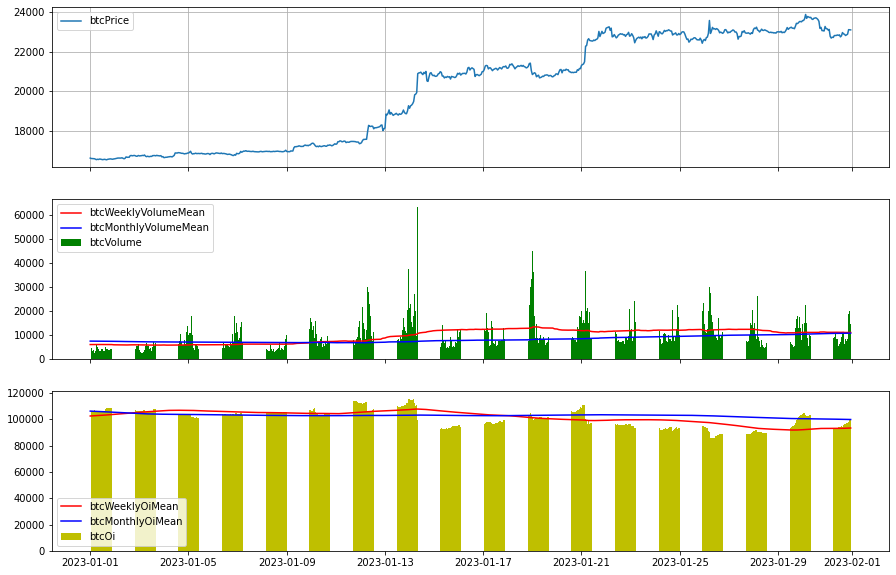

In [24]:
lastMonth = 31*24
figBtc, (axBtc, ax1Btc, ax2Btc) = plt.subplots(3,1,sharex=True, figsize=(15,10))
# figBtc.subplots_adjust(bottom=0.5)
axBtc.grid(True)
axBtc.plot(btcOiVolumeDf.iloc[-lastMonth:].close, label='btcPrice')
axBtc.legend()
ax1Btc.bar(btcOiVolumeDf.iloc[-lastMonth:].index, btcOiVolumeDf.iloc[-lastMonth:].volume, color='g', width=0.02, label='btcVolume')
ax1Btc.plot(ta.MA(btcOiVolumeDf.volume, shortPeriod).iloc[-lastMonth:], color='r', label='btcWeeklyVolumeMean')
ax1Btc.plot(ta.MA(btcOiVolumeDf.volume, longPeriod).iloc[-lastMonth:], color='b', label='btcMonthlyVolumeMean')
ax1Btc.legend(loc='upper left')
ax2Btc.bar(btcOiVolumeDf.iloc[-lastMonth:].index, btcOiVolumeDf.oi.iloc[-lastMonth:], color='y', width=0.02, label='btcOi')
ax2Btc.plot(ta.MA(btcOiVolumeDf.oi, shortPeriod).iloc[-lastMonth:], color='r', label='btcWeeklyOiMean')
ax2Btc.plot(ta.MA(btcOiVolumeDf.oi, longPeriod).iloc[-lastMonth:], color='b', label='btcMonthlyOiMean')
ax2Btc.legend()
figBtc.savefig('oiVolumePriceBtc')

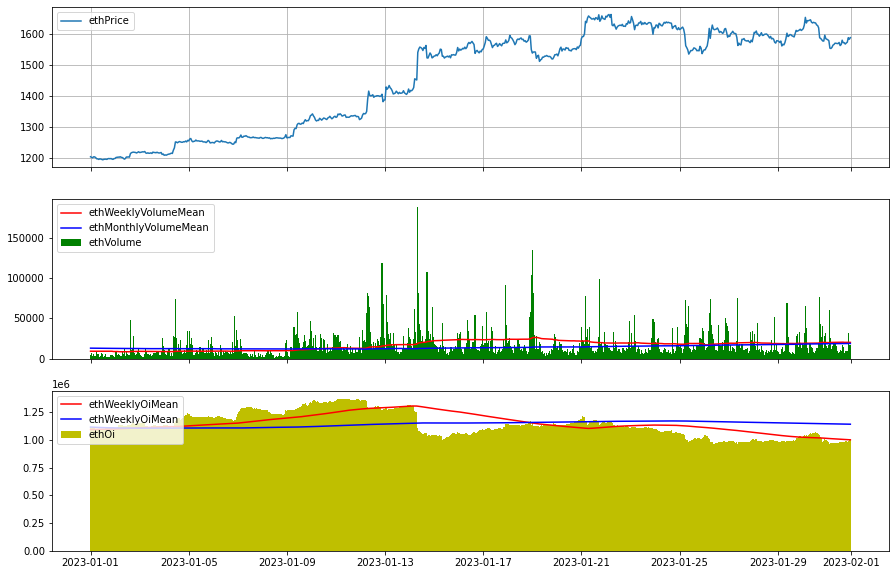

In [25]:
lastMonth = 31*24
figEth, (axEth,ax1Eth, ax2Eth) = plt.subplots(3,1,sharex=True, figsize=(15,10))
# figEth.subplots_adjust(bottom=0.5)
axEth.grid(True)
axEth.plot(ethOiVolumeDf.iloc[-lastMonth:].close, label='ethPrice')
axEth.legend(loc='upper left')
ax1Eth.bar(ethOiVolumeDf.iloc[-lastMonth:].index, ethOiVolumeDf.iloc[-lastMonth:].volume, color='g', width=0.045, label='ethVolume')
ax1Eth.plot(ta.MA(ethOiVolumeDf.volume, shortPeriod).iloc[-lastMonth:], color='r', label='ethWeeklyVolumeMean')
ax1Eth.plot(ta.MA(ethOiVolumeDf.volume, longPeriod).iloc[-lastMonth:], color='b', label='ethMonthlyVolumeMean')
ax1Eth.legend(loc='upper left')
ax2Eth.bar(ethOiVolumeDf.iloc[-lastMonth:].index, ethOiVolumeDf.oi.iloc[-lastMonth:], color='y', width=0.045, label='ethOi')
ax2Eth.plot(ta.MA(ethOiVolumeDf.oi, shortPeriod).iloc[-lastMonth:], color='r', label='ethWeeklyOiMean')
ax2Eth.plot(ta.MA(ethOiVolumeDf.oi, longPeriod).iloc[-lastMonth:], color='b', label='ethWeeklyOiMean')
ax2Eth.legend(loc='upper left')
figEth.savefig('oiVolumePriceEth')

In [26]:
close = oiVolumeDf.close.unstack()
volume = oiVolumeDf.volume.unstack()
oi = oiVolumeDf.oi.unstack()

In [27]:
oi

symbol,btc,eth
datetime,,
2022-12-03 18:00:00,129720.446,1503942.764
2022-12-03 19:00:00,129429.417,1495373.362
2022-12-03 20:00:00,129868.580,1484744.873
2022-12-03 21:00:00,130305.894,1479420.987
2022-12-03 22:00:00,130300.553,1469283.662
...,...,...
2023-01-31 19:00:00,97022.316,985660.888
2023-01-31 20:00:00,97457.766,984310.435
2023-01-31 21:00:00,98378.574,992941.132


In [28]:
closeMaRatio = close.rolling(shortPeriod).mean()/close.rolling(longPeriod).mean()
volumeMaRatio = volume.rolling(shortPeriod).mean()/volume.rolling(longPeriod).mean()
oiMaRatio = oi.rolling(shortPeriod).mean()/oi.rolling(longPeriod).mean()

In [29]:
def cal_pctChange(data, lastDay, periodList=[7]):
    pctChangeDict = {}
    for period in periodList:
        pctChangeDict[str(period)+'Day'] = round((data.loc[lastDay]/data.loc[lastDay-timedelta(hours=period*24)]-1)*100, 2)
    pctChangeDf = pd.Series(pctChangeDict)
    return pctChangeDf

In [30]:
endTime = oiMaRatio.index[-1]
maChangeDf = pd.DataFrame({
    'btcCloseRatioPctChange': cal_pctChange(closeMaRatio.btc, endTime, [1, 3, 5, 8, 13]),
    'ethCloseRatioPctChange': cal_pctChange(closeMaRatio.eth, endTime, [1, 3, 5, 8, 13]),
    'btcVolumeRatioPctChange': cal_pctChange(volumeMaRatio.btc, endTime, [1, 3, 5, 8, 13]),
    'ethVolumeRatioPctChange': cal_pctChange(volumeMaRatio.eth, endTime, [1, 3, 5, 8, 13]),   
    'btcOpenInterestRatioPctChange': cal_pctChange(oiMaRatio.btc, endTime, [1, 3, 5, 8, 13]),
    'ethOpenInterestRatioPctChange': cal_pctChange(oiMaRatio.eth, endTime, [1, 3, 5, 8, 13]),
})

In [31]:
maChangeDfT = round(maChangeDf.T, 2)

In [32]:
maChangeDfT['avg'] = maChangeDfT.mean(axis=1)

In [33]:
maChangeDfT

,1Day,3Day,5Day,8Day,13Day,avg
btcCloseRatioPctChange,-1.13,-2.86,-3.61,-3.59,-1.24,-2.486
ethCloseRatioPctChange,-1.37,-3.79,-5.77,-7.62,-7.21,-5.152
btcVolumeRatioPctChange,-2.69,-7.36,-18.09,-20.58,-36.41,-17.026
ethVolumeRatioPctChange,-0.55,0.14,-4.75,-10.96,-39.13,-11.050
btcOpenInterestRatioPctChange,0.72,2.23,-0.43,-3.10,-4.89,-1.094
ethOpenInterestRatioPctChange,-0.88,-3.08,-6.69,-9.48,-12.06,-6.438


In [34]:
maChangeDfT.to_excel('RatioPctChange.xlsx')

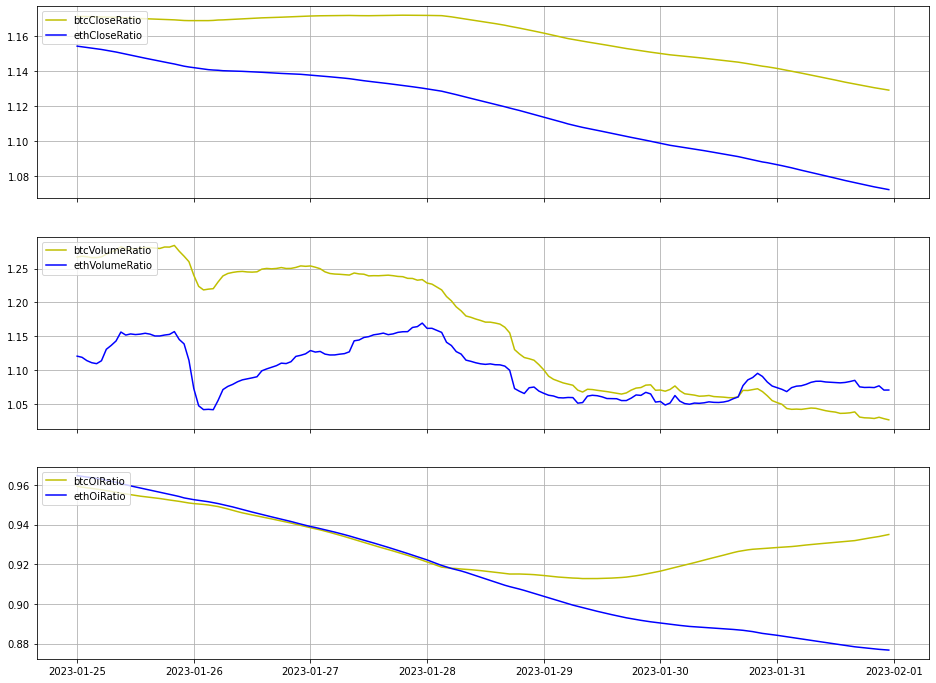

In [35]:
f2Coin, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(16,12))
ax1.plot(closeMaRatio.btc.iloc[-24*7:], 'y', label='btcCloseRatio')
ax1.plot(closeMaRatio.eth.iloc[-24*7:], 'b', label='ethCloseRatio')
ax1.legend(loc='upper left')
ax1.grid()
ax2.plot(volumeMaRatio.btc.iloc[-24*7:], 'y', label='btcVolumeRatio')
ax2.plot(volumeMaRatio.eth.iloc[-24*7:], 'b', label='ethVolumeRatio')
ax2.legend(loc='upper left')
ax2.grid()
ax3.plot(oiMaRatio.btc.iloc[-24*7:], 'y', label='btcOiRatio')
ax3.plot(oiMaRatio.eth.iloc[-24*7:], 'b', label='ethOiRatio')
ax3.legend(loc='upper left')
ax3.grid()
f2Coin.savefig('RatioChart')